In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpu_devices))
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

Num GPUs Available:  1


In [5]:
import sys
sys.path.append('..')

In [10]:
checkpoint_dir = '/scratch/pstjohn/uniparc/12_layer_bs24_adamw_20200527'
tf.train.latest_checkpoint(checkpoint_dir)

'/scratch/pstjohn/uniparc/12_layer_bs24_adamw_20200527/weights.160-7.55'

In [12]:
from bert.model import create_albert_model

dimension = 768

model = create_albert_model(model_dimension=dimension,
                            transformer_dimension=dimension * 4,
                            num_attention_heads=dimension // 64,
                            num_transformer_layers=12,
                            dropout_rate=0.,
                            max_relative_position=64,
                            final_layernorm=False)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
# model.load_weights('/cs')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 768)         18432     
_________________________________________________________________
transformer_12 (Transformer) (None, None, 768)         7096128   
_________________________________________________________________
transformer_13 (Transformer) (None, None, 768)         7096128   
_________________________________________________________________
transformer_14 (Transformer) (None, None, 768)         7096128   
_________________________________________________________________
transformer_15 (Transformer) (None, None, 768)         7096128   
_________________________________________________________________
transformer_16 (Transformer) (None, None, 768)         709612

In [17]:
from bert.dataset import create_masked_input_dataset
import os

valid_data = create_masked_input_dataset(
    sequence_path='/scratch/pstjohn/uniparc/dev_uniref50_split/dev_50_*.txt.gz',
    max_sequence_length=4096,
    batch_size=24,
    masking_freq=0.15,
    fix_sequence_length=False)

In [18]:
masked_seq, true_values = next(iter(valid_data))

In [19]:
from bert.losses import ECE
predictions = model.predict(masked_seq)
ECE(true_values, predictions)

<tf.Tensor: shape=(), dtype=float32, numpy=7.058393>

In [20]:
predictions[:, :, 0].max()

-11.568874

In [21]:
masked_entries = tf.not_equal(true_values, 0)
y_true_mask = tf.boolean_mask(true_values, masked_entries)
y_logit_mask = tf.boolean_mask(predictions, masked_entries)
y_pred_mask = y_logit_mask.numpy().argmax(-1)

In [22]:
from sklearn.metrics import accuracy_score

In [23]:
accuracy_score(y_true_mask.numpy(), y_pred_mask)

0.39720713731574864

In [24]:
y_true_mask.numpy().shape

(1289,)

In [25]:
aas = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
confusion_mat = pd.DataFrame([y_pred_mask, y_true_mask.numpy()], index=['Pred', 'True']
                            ).T.groupby(['Pred', 'True']).size().reset_index().pivot(
    index='True', columns='Pred', values=0).fillna(0)

confusion_mat.index = aas
confusion_mat.columns = aas

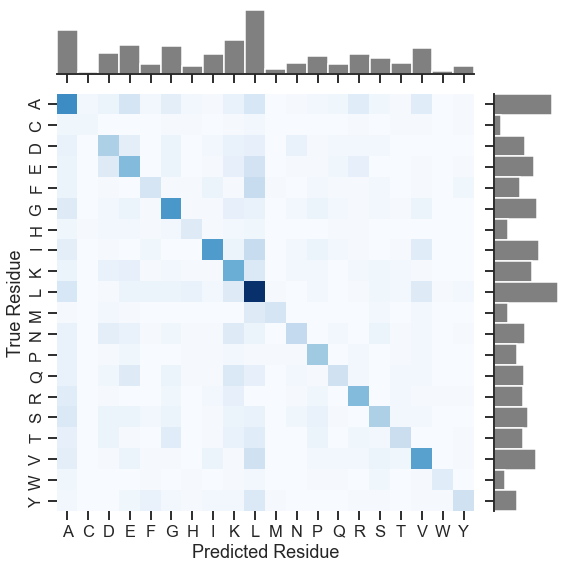

In [26]:
height = 8
ratio = 5

# Set up the subplot grid
f = plt.figure(figsize=(height, height))
gs = plt.GridSpec(ratio + 1, ratio + 1)

ax_joint = f.add_subplot(gs[1:, :-1])
ax_marg_x = f.add_subplot(gs[0, :-1], sharex=ax_joint)
ax_marg_y = f.add_subplot(gs[1:, -1], sharey=ax_joint)

fig = f
ax_joint = ax_joint
ax_marg_x = ax_marg_x
ax_marg_y = ax_marg_y

# Turn off tick visibility for the measure axis on the marginal plots
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Turn off the ticks on the density axis for the marginal plots
plt.setp(ax_marg_x.yaxis.get_majorticklines(), visible=False)
plt.setp(ax_marg_x.yaxis.get_minorticklines(), visible=False)
plt.setp(ax_marg_y.xaxis.get_majorticklines(), visible=False)
plt.setp(ax_marg_y.xaxis.get_minorticklines(), visible=False)
plt.setp(ax_marg_x.get_yticklabels(), visible=False)
plt.setp(ax_marg_y.get_xticklabels(), visible=False)
ax_marg_x.yaxis.grid(False)
ax_marg_y.xaxis.grid(False)

sns.heatmap(confusion_mat, ax=ax_joint, cbar=False, cmap='Blues')
_ = ax_marg_x.bar(aas, height=confusion_mat.sum(0), width=1., align='edge', facecolor='.5')
_ = ax_marg_y.barh(aas, width=confusion_mat.sum(1), height=1., align='edge', facecolor='.5')

sns.despine(ax=ax_marg_x, left=True)
sns.despine(ax=ax_marg_y, bottom=True)

_ = ax_joint.set_xticks(np.arange(20) + 0.5)
_ = ax_joint.set_xticklabels(aas)
_ = ax_joint.set_yticks(np.arange(20) + 0.5)
_ = ax_joint.set_yticklabels(aas)

ax_joint.set_ylabel('True Residue')
ax_joint.set_xlabel('Predicted Residue')

plt.tight_layout()
# plt.savefig('figures/confusion_matrix.svg')

In [27]:
def get_attention(l):
    inputs = l.input
    mask = l.input_mask
    
    input_shape = tf.shape(inputs) # [B, S, N*H]

    # query and key can be the same vector
    qk = l.attention_layer.transpose_scores(l.attention_layer.qk_layer(inputs))  # [B,N,S,H]
    value = l.attention_layer.transpose_scores(l.attention_layer.value_layer(inputs))  # [B,N,S,H]

    # Equation 1 of "Attention is all you need"
    attention_scores = l.attention_layer.calculate_attention(qk, input_shape)  # [B,N,S,S]

    # zero out masked values
    attention_mask = l.attention_layer.create_attention_mask(input_shape, mask)
    attention_scores = attention_scores + (1. - attention_mask) * -10000.0

    attention_probs = tf.nn.softmax(attention_scores)  # [B,N,S,S]
    return attention_probs


In [28]:
# attentions = attention_model(masked_seq).numpy()

# plt.figure(figsize=(6,5))
# sns.heatmap(attentions[2, :290, :290], cmap='Blues')
# plt.tight_layout()
# plt.savefig('figures/attention_map.svg')

In [29]:
np.arange(-20, 20, 5)

array([-20, -15, -10,  -5,   0,   5,  10,  15])

In [30]:
inputs = tf.keras.Model(model.layers[1].input, model.layers[1].output)(masked_seq)
inputs._keras_mask

<tf.Tensor: shape=(24, 933), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

In [31]:
transformer = model.layers[2]

In [32]:
self = transformer.attention_layer
mask = inputs._keras_mask
training=True

from bert.attention_utils import create_attention_mask, relative_attention_inner, initializer

In [33]:
input_shape = tf.shape(inputs) # [B, S, N*H]

# query and key can be the same vector
query = self.transpose_scores(self.query_layer(inputs))  # [B,N,S,H]
key = self.transpose_scores(self.key_layer(inputs))  # [B,N,S,H]
value = self.transpose_scores(self.value_layer(inputs))  # [B,N,S,H]

# Equation 1 of "Attention is all you need"
attention_scores = self.calculate_attention(query, key, input_shape)  # [B,N,S,S]

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(self.relations_keys_embedding.weights[0].numpy())

In [ ]:
# zero out masked values
attention_mask = self.create_attention_mask(input_shape, mask, query.dtype)
attention_scores = attention_scores * 1000 + (1. - attention_mask) * -10000.0
attention_probs = tf.nn.softmax(attention_scores)  # [B,N,S,S]

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(attention_probs[2, 0].numpy())

In [ ]:
attention_probs.numpy().shape

In [ ]:
attentions = attention_probs.numpy().mean(1)

In [ ]:
lengths = inputs._keras_mask.numpy().sum(1)

In [ ]:
input_index = 1

di = list(np.diag_indices(lengths[input_index]))

def get_offset(i):
    return np.mean(attentions[input_index, di[0][20:-20] + i, di[1][20:-20]])

sns.boxplot(data=pd.DataFrame([get_offset(i) for i in np.arange(-20, 21)], index=np.arange(-20, 21)).T, fliersize=0)
plt.xticks(ticks=np.arange(0, 45, 5), labels=np.arange(-20, 25, 5))
sns.despine(trim=True, offset=4)
plt.xlabel('Residue Offset')
plt.ylabel('Fractional Attention')
plt.tight_layout()
# plt.savefig('figures/attention_offset.svg')

In [ ]:
context_layer = tf.matmul(attention_probs, value)  # [B,N,S,S]

In [ ]:
context_layer.shape

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(context_layer[2, 0].numpy())

In [ ]:
context_layer = tf.transpose(a=context_layer, perm=[0, 2, 1, 3])            

In [ ]:
context_layer.shape

In [ ]:
output_shape = [input_shape[0], input_shape[1], self.num_heads*self.units]
context_layer = tf.reshape(context_layer, output_shape)

In [ ]:
context_layer.shape

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(context_layer[0, :, :10].numpy())

In [ ]:
mask = inputs._keras_mask
attention_mask = self.create_attention_mask(mask)
attention_scores_mask = attention_scores + (1. - attention_mask) * -10000.0
attention_probs = tf.nn.softmax(attention_scores_mask)  # [B,N,S,S]
context_layer = tf.matmul(attention_probs, value)  # [B,N,S,S]

input_shape  = tf.shape(inputs)
output_shape = [input_shape[0], input_shape[1], self.num_heads*self.units]
# context_layer = tf.reshape(context_layer, output_shape)

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(attention_mask[3, 0].numpy())

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(attention_scores[3, 0].numpy())

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(attention_scores_mask[3, 0].numpy())

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(attention_probs[3, 0].numpy())

In [ ]:
context_layer.shape

In [ ]:
context_layer.shape

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(tf.reshape(tf.transpose(a=context_layer, perm=[0, 2, 1, 3]), input_shape)[3].numpy())